In [1]:
!nvidia-smi

Wed Jul 19 10:33:35 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1060        Off | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8               4W /  78W |      6MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
#!git clone https://github.com/yhenon/pytorch-retinanet.git

In [2]:
!pip install pycocotools

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


/content/drive/MyDrive/TT/TRASH DETECTION/retinanet

In [3]:
import os

import re
import cv2
import time
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw


import torch
import torch.optim as optim
import torchvision.transforms as T
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset

from retinanet.retinanet import model
from retinanet.retinanet.dataloader import collater, Resizer, Augmenter, Normalizer, UnNormalizer, CSVDataset
#from retinanet.retinanet import model
#from retinanet.retinanet.dataloader import collater, Resizer, Augmenter, Normalizer, UnNormalizer, CSVDataset
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

/home/dev-jhandry/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
path_to_anno = 'data/annotations.json'

In [5]:
with open(path_to_anno) as f:
  data = json.load(f)


for i in data['categories']:
  print(i)

{'supercategory': 'Desconocido', 'id': 0, 'name': 'Aluminium foil'}
{'supercategory': 'Bateria', 'id': 1, 'name': 'Battery'}
{'supercategory': 'Plásticos duros', 'id': 2, 'name': 'Aluminium blister pack'}
{'supercategory': 'Plásticos duros', 'id': 3, 'name': 'Carded blister pack'}
{'supercategory': 'Empaques PET', 'id': 4, 'name': 'Other plastic bottle'}
{'supercategory': 'Empaques PET', 'id': 5, 'name': 'Clear plastic bottle'}
{'supercategory': 'Vidrio', 'id': 6, 'name': 'Glass bottle'}
{'supercategory': 'Tapas plasticas', 'id': 7, 'name': 'Plastic bottle cap'}
{'supercategory': 'Desconocido', 'id': 8, 'name': 'Metal bottle cap'}
{'supercategory': ' Vidrio', 'id': 9, 'name': 'Broken glass'}
{'supercategory': 'Latas', 'id': 10, 'name': 'Food Can'}
{'supercategory': 'Latas', 'id': 11, 'name': 'Aerosol'}
{'supercategory': 'Latas', 'id': 12, 'name': 'Drink can'}
{'supercategory': 'Carton', 'id': 13, 'name': 'Toilet tube'}
{'supercategory': 'Carton', 'id': 14, 'name': 'Other carton'}
{'sup

In [7]:
# Get data from annotations
path_to_anno = 'data/annotations.json'

with open(path_to_anno) as f:
  data = json.load(f)

print(type(data))
print()

# required classes for my problem statement
classes_req = ['Papel','Carton','Empaques PET','Plásticos duros','Plásticos flexibles', 'Latas', 'Vidrio',' Envases de Tetra Pak','Espuma flex', 'Tapas plasticas']
classes = {}
classes_id = {}

for i in data['categories']:
  if(i['supercategory'] in classes_req):
    classes[i['id']] = i['name']
    print(i['supercategory'])

print(classes)
print("Number of classes: ", len(classes))
print()

#Get image path and data
images_data = {}

for i in data['images']:
  temp = {
      'file_n': 'data/'+i['file_name'],
      'width': i['width'],
      'height': i['height'],
  }
  images_data[i['id']] = temp
print("Image data gathered")
print()

#Check if bounding box is valid
def is_valid(x_min, y_min, x_max, y_max, width, height):
    return (x_min in range(0, width)) and (x_max in range(0, width)) and (y_min in range(0, height)) and (y_max in range(0, width))


filter_class = {
    'Aluminium blister pack': 'Plásticos duros',
    'Carded blister pack': 'Plásticos duros',
    'Other plastic bottle': 'Empaques PET',
    'Clear plastic bottle': 'Empaques PET',
    'Glass bottle': 'Vidrio',
    'Plastic bottle cap': 'Tapas plasticas',
    'Broken glass': 'Vidrio',
    'Food Can': 'Latas',
    'Aerosol': 'Latas',
    'Drink can': 'Latas',
    'Toilet tube': 'Carton',
    'Other carton': 'Carton',
    'Egg carton': 'Carton',
    'Drink carton': ' Envases de Tetra Pak',
    'Corrugated carton': 'Carton',
    'Meal carton': 'Carton',
    'Pizza box': 'Carton',
    'Paper cup': 'Plásticos flexibles',
    'Disposable plastic cup': 'Plásticos flexibles',
    'Foam cup': 'Espuma flex',
    'Glass cup': 'Vidrio',
    'Other plastic cup': 'Plásticos duros',
    'Glass jar': 'Vidrio',
    'Plastic lid': 'Plásticos duros',
    'Other plastic': 'Plásticos duros',
    'Magazine paper': 'Papel',
    'Wrapping paper': 'Papel',
    'Normal paper': 'Papel',
    'Paper bag': 'Papel',
    'Plastified paper bag': 'Papel',
    'Plastic film': 'Plásticos duros	',
    'Six pack rings': 'Plásticos flexibles',
    'Garbage bag': 'Plásticos flexibles',
    'Other plastic wrapper': 'Plásticos flexibles',
    'Single-use carrier bag': 'Plásticos flexibles',
    'Polypropylene bag': 'Plásticos flexibles',
    'Crisp packet': 'Plásticos flexibles',
    'Spread tub': 'Plásticos duros',
    'Tupperware': 'Plásticos duros',
    'Disposable food container': 'Empaques PET',
    'Foam food container': 'Espuma flex',
    'Other plastic container': 'Plásticos duros',
    'Plastic glooves': 'Plásticos flexibles',
    'Plastic utensils': 'Plásticos duros',
    'Plastic straw': 'Plásticos flexibles',
    'Paper straw': 'Papel',
    'Styrofoam piece': 'Espuma flex',
    'Aluminium foil':'Desconocido',
    'Battery':'Bateria',
    'Metal bottle cap':'Desconocido',
    'Food waste':'Inorganico',
    'Metal lid':'Desconocido',
    'Tissues':'Desconocido',
    'Pop tab':'Desconocido',
    'Rope & strings':'Desconocido',
    'Scrap metal':'Desconocido',
    'Shoe':'Desconocido',
    'Squeezable tube':'Desconocido',
    'Unlabeled litter':'Desconocido',
    'Cigarette':'Desconocido'
    }


# Group images with their data
images_with_anno = []
not_valid=0
for i in data['annotations']:
  if(i['category_id'] in classes.keys()):
    img_d = images_data[i['image_id']]
    x_min= int(i['bbox'][0])
    y_min= int(i['bbox'][1])
    x_max= int(i['bbox'][0]+i['bbox'][2])
    y_max= int(i['bbox'][1]+i['bbox'][3])
    valid = is_valid(x_min, y_min, x_max, y_max, img_d['width'], img_d['height'])
    temp = {
        'image_name': img_d['file_n'],
        'x_min': int(i['bbox'][0]),
        'y_min': int(i['bbox'][1]),
        'x_max': int(i['bbox'][0]+i['bbox'][2]),
        'y_max': int(i['bbox'][1]+i['bbox'][3]),
        'class_name': filter_class[classes[i['category_id']]],
    }
    if(valid):
        images_with_anno.append(temp)
    else:
        not_valid+=1

print("Complete dict generated", "\nFound not valid: ", not_valid)
print()

<class 'dict'>

Plásticos duros
Plásticos duros
Empaques PET
Empaques PET
Vidrio
Tapas plasticas
Latas
Latas
Latas
Carton
Carton
Carton
 Envases de Tetra Pak
Carton
Carton
Carton
Espuma flex
Plásticos duros
Plásticos duros
Plásticos duros
Papel
Papel
Papel
Papel
Papel
Plásticos flexibles
Plásticos flexibles
Plásticos flexibles
Plásticos flexibles
Plásticos flexibles
Plásticos flexibles
Plásticos duros
Plásticos duros
Empaques PET
Espuma flex
Plásticos duros
Plásticos flexibles
Plásticos duros
Plásticos flexibles
Papel
Espuma flex
{2: 'Aluminium blister pack', 3: 'Carded blister pack', 4: 'Other plastic bottle', 5: 'Clear plastic bottle', 6: 'Glass bottle', 7: 'Plastic bottle cap', 10: 'Food Can', 11: 'Aerosol', 12: 'Drink can', 13: 'Toilet tube', 14: 'Other carton', 15: 'Egg carton', 16: 'Drink carton', 17: 'Corrugated carton', 18: 'Meal carton', 19: 'Pizza box', 22: 'Foam cup', 24: 'Other plastic cup', 27: 'Plastic lid', 29: 'Other plastic', 30: 'Magazine paper', 32: 'Wrapping paper',

In [8]:
df = pd.DataFrame(images_with_anno)

In [9]:
train_df, test_df = train_test_split(df, test_size=0.2)

In [10]:
train_df.to_csv('data/annotations.csv', index=False, header=None)

In [11]:
with open('data/classes.csv', 'w') as f:
  for i, (class_name) in enumerate(train_df['class_name'].unique()):
    f.write(f'{class_name},{i}\n')

In [12]:
train_data = CSVDataset('data/annotations.csv', 'data/classes.csv', transform = T.Compose([Augmenter(), Normalizer(), Resizer()]))

In [13]:
test_data = CSVDataset('data/annotations.csv', 'data/classes.csv', transform = T.Compose([Augmenter(), Normalizer(), Resizer()]))

In [25]:
# DataLoaders
train_data_loader = DataLoader(
    train_data,
    batch_size = 32,
    shuffle = True,
    num_workers = 0,
    collate_fn = collater
)



test_data_loader = DataLoader(
    test_data,
    batch_size = 1,
    shuffle = True,
    num_workers = 0,
    collate_fn = collater
)

In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
print("Device: ", device)

Device:  cuda


In [16]:
#Load saved model
retinanet = torch.load('retinanet/modelpretrainet.pt')

In [27]:
retinanet = model.resnet50(num_classes = 10, pretrained = True)

In [28]:
### Preparing model for training

# Defininig Optimizer
optimizer = torch.optim.Adam(retinanet.parameters(), lr = 0.0001)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.5)

retinanet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

CODIGO con PRESICION

total_correct = 0
total_samples = 0

def train_one_epoch(epoch_num, train_data_loader):

    print("Epoch - {} Started".format(epoch_num))
    st = time.time()

    retinanet.train()

    epoch_loss = []
    total_correct = 0
    total_samples = 0

    for iter_num, data in enumerate(train_data_loader):

        # Reseting gradients after each iter
        optimizer.zero_grad()

        # Forward
        classification_loss, regression_loss = retinanet([data['img'].cuda().float(), data['annot'].cuda().float()])

        # Obtener predicciones
        pred_scores, pred_boxes = retinanet.predict([data['img'].cuda().float()])

        # Calcular la precisión
        predicted_labels = torch.argmax(pred_scores, dim=1)
        correct_predictions = (predicted_labels == data['annot'].cuda().long()).sum().item()
        total_correct += correct_predictions
        total_samples += data['img'].size(0)

        # Calculating Loss
        classification_loss = classification_loss.mean()
        regression_loss = regression_loss.mean()

        loss = classification_loss + regression_loss

        if bool(loss == 0):
            continue

        # Calculating Gradients
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(retinanet.parameters(), 0.1)

        # Updating Weights
        optimizer.step()

        #Epoch Loss
        epoch_loss.append(float(loss))

        if(iter_num%10==0):
            print(
            'Epoch: {} | Iteration: {} | Classification loss: {:1.5f} | Regression loss: {:1.5f} | Running loss: {:1.5f}'.format(
                epoch_num, iter_num, float(classification_loss), float(regression_loss), np.mean(epoch_loss)))

        del classification_loss
        del regression_loss

    # Calcular y mostrar la precisión
    accuracy = total_correct / total_samples
    print('Accuracy: {:.2%}'.format(accuracy))

    et = time.time()
    print("\n Total Time - {}\n".format(int(et - st)))

In [19]:
### One Epoch - Train

def train_one_epoch(epoch_num, train_data_loader):

    print("Epoch - {} Started".format(epoch_num))
    st = time.time()

    retinanet.train()

    epoch_loss = []

    for iter_num, data in enumerate(train_data_loader):

        # Reseting gradients after each iter
        optimizer.zero_grad()

        # Forward
        classification_loss, regression_loss = retinanet([data['img'].cuda().float(), data['annot'].cuda().float()])

        # Calculating Loss
        classification_loss = classification_loss.mean()
        regression_loss = regression_loss.mean()

        loss = classification_loss + regression_loss

        if bool(loss == 0):
            continue

        # Calculating Gradients
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(retinanet.parameters(), 0.1)

        # Updating Weights
        optimizer.step()

        #Epoch Loss
        epoch_loss.append(float(loss))

        if(iter_num%10==0):
            print(
            'Epoch: {} | Iteration: {} | Classification loss: {:1.5f} | Regression loss: {:1.5f} | Running loss: {:1.5f}'.format(
                epoch_num, iter_num, float(classification_loss), float(regression_loss), np.mean(epoch_loss)))



        del classification_loss
        del regression_loss

    # Update the learning rate
    #if lr_scheduler is not None:
        #lr_scheduler.step()

    et = time.time()
    print("\n Total Time - {}\n".format(int(et - st)))

In [20]:
def calculate_accuracy(outputs, targets, threshold=0.5):
    predicted_labels = outputs > threshold
    correct_labels = (predicted_labels == targets).all(dim=1)
    accuracy = torch.sum(correct_labels).item() / len(targets)
    return accuracy

def valid_one_epoch(ver_no, valid_data_loader):
    print("Validation - Started")
    st = time.time()

    epoch_loss = []
    epoch_accuracy = []

    for iter_num, data in enumerate(valid_data_loader):
        with torch.no_grad():
            # Forward
            classification_loss, regression_loss = retinanet([data['img'].cuda().float(), data['annot'].cuda().float()])

            # Calculating Loss
            classification_loss = classification_loss.mean()
            regression_loss = regression_loss.mean()
            loss = classification_loss + regression_loss

            # Calculating Accuracy
            batch_accuracy = calculate_accuracy(classification_loss, data['annot'].cuda().float())
            epoch_accuracy.append(batch_accuracy)

            # Epoch Loss
            epoch_loss.append(float(loss))

            if iter_num % 10 == 0:
                print(
                    'Iteration: {} | Classification loss: {:1.5f} | Regression loss: {:1.5f} | Running loss: {:1.5f} | Accuracy: {:1.5f}'.format(
                        iter_num, float(classification_loss), float(regression_loss), np.mean(epoch_loss),
                        np.mean(epoch_accuracy)))

            del classification_loss
            del regression_loss

    et = time.time()
    print("\n Total Time - {}\n".format(int(et - st)))

    # Save Model after each epoch
    torch.save(retinanet, "retinanet_gwd" + str(ver_no) + ".pt")

hh

In [29]:
epochs = 100

In [30]:
torch.cuda.empty_cache()

In [31]:
### Training Loop
for epoch in range(epochs):

    # Call train function
    train_one_epoch(epoch, train_data_loader)

    # Call valid function
#     valid_one_epoch(epoch, test_data_loader)

Epoch - 0 Started


OutOfMemoryError: CUDA out of memory. Tried to allocate 22.00 MiB (GPU 0; 5.93 GiB total capacity; 5.60 GiB already allocated; 13.62 MiB free; 5.78 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
valid_one_epoch(epoch, test_data_loader)

Validation - Started
Iteration: 0 | Classification loss: 0.38792 | Regression loss: 0.27680 | Running loss: 0.66471
Iteration: 10 | Classification loss: 0.55749 | Regression loss: 0.34212 | Running loss: 0.54775
Iteration: 20 | Classification loss: 0.21511 | Regression loss: 0.09365 | Running loss: 0.50502
Iteration: 30 | Classification loss: 0.23711 | Regression loss: 0.30196 | Running loss: 0.47959
Iteration: 40 | Classification loss: 0.26041 | Regression loss: 0.10620 | Running loss: 0.48654
Iteration: 50 | Classification loss: 0.38496 | Regression loss: 0.31976 | Running loss: 0.49408
Iteration: 60 | Classification loss: 0.26833 | Regression loss: 0.22684 | Running loss: 0.51162
Iteration: 70 | Classification loss: 0.22877 | Regression loss: 0.17267 | Running loss: 0.52949
Iteration: 80 | Classification loss: 0.48911 | Regression loss: 0.28663 | Running loss: 0.57299
Iteration: 90 | Classification loss: 0.19695 | Regression loss: 0.26833 | Running loss: 0.57080
Iteration: 100 | Cla

tensor([], device='cuda:0') tensor([], device='cuda:0', dtype=torch.int64) tensor([], device='cuda:0')


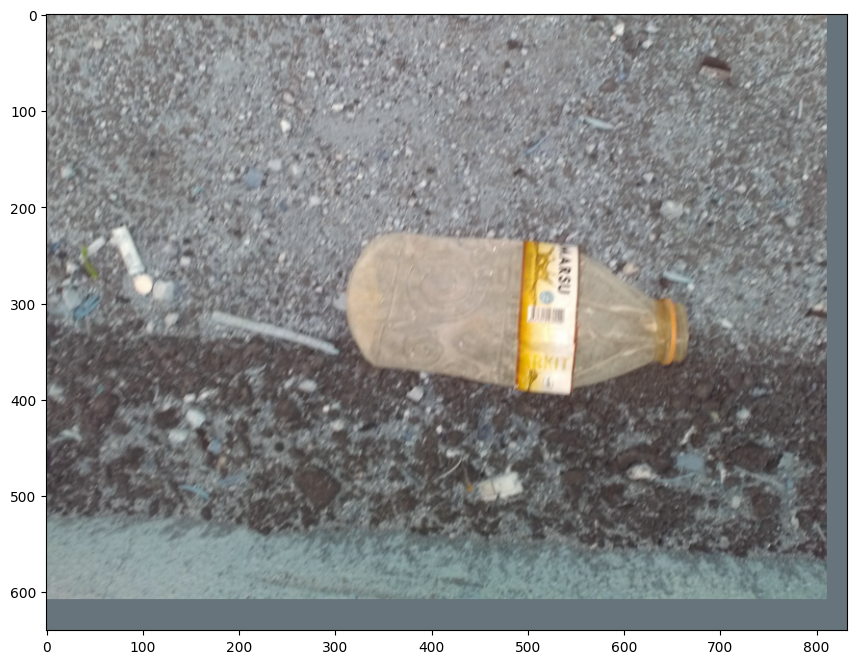

In [ ]:
### Sample Results
retinanet.eval()
unnormalize = UnNormalizer()
b = []

for iter_num, data in enumerate(test_data_loader):

    # Getting Predictions
    scores, classification, transformed_anchors = retinanet(data['img'].cuda().float())
    b.append(data['img'].shape)
    print(scores, classification, transformed_anchors)

    idxs = np.where(scores.cpu()>0.3)
    img = np.array(255 * unnormalize(data['img'][0, :, :, :])).copy()

    img[img<0] = 0
    img[img>255] = 255

    img = np.transpose(img, (1, 2, 0))

    img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for j in range(idxs[0].shape[0]):
        bbox = transformed_anchors[idxs[0][j], :]
        x1 = int(bbox[0])
        y1 = int(bbox[1])
        x2 = int(bbox[2])
        y2 = int(bbox[3])
        b.append((x1,y1,x2,y2))

        cv2.rectangle(img, (x1, y1), (x2, y2), color = (0, 0, 255), thickness = 5)

    ax.imshow(img)

    break

In [ ]:
import skimage.io
import skimage.transform
import skimage.color
import skimage

In [ ]:
img_transforms  = T.Compose([Augmenter(), Normalizer(), Resizer()])
def do_transforms(image):

    #Normalizer
    s_mean = np.array([[[0.485, 0.456, 0.406]]])
    s_std = np.array([[[0.229, 0.224, 0.225]]])
    image = (image.astype(np.float32)-s_mean)/s_std

    #resize
    min_side=608
    max_side=1024
    rows, cols, cns = image.shape
    smallest_side = min(rows, cols)
    scale = min_side / smallest_side
    largest_side = max(rows, cols)

    if largest_side * scale > max_side:
        scale = max_side / largest_side
    image = skimage.transform.resize(image, (int(round(rows*scale)), int(round((cols*scale)))))
    rows, cols, cns = image.shape
    pad_w = 32 - rows%32
    pad_h = 32 - cols%32

    new_image = np.zeros((rows + pad_w, cols + pad_h, cns)).astype(np.float32)
    new_image[:rows, :cols, :] = image.astype(np.float32)

    return torch.from_numpy(new_image)


In [ ]:
def show_pred_on_image(path, model, thres = 0.5):
    model.eval()
    unnormalize = UnNormalizer()
    im = Image.open(path).convert('RGB')
    #im = im / 255.
    img = do_transforms(np.array(im)/255.)
    img = img.permute(2,0,1)
    img = img.unsqueeze(0)
    print(img.shape)
    st=time.time()
    scores, classification, transformed_anchors = model(img.cuda().float())
    et=time.time()
    print("\n Total Time - {}\n".format((et - st)))
    print("Clasificacion")
    classification
    idxs = np.where(scores.cpu()>thres)
    img = np.array(255 * unnormalize(img[0, :, :, :])).copy()

    img[img<0] = 0
    img[img>255] = 255

    img = np.transpose(img, (1, 2, 0))

    img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    k = 0
    for j in range(idxs[0].shape[0]):
        bbox = transformed_anchors[idxs[0][j], :]
        x1 = int(bbox[0])
        y1 = int(bbox[1])
        x2 = int(bbox[2])
        y2 = int(bbox[3])
        b.append((x1,y1,x2,y2))

        cv2.rectangle(img, (x1, y1), (x2, y2), color = (0, 0, 255), thickness = 2)
        class_index = classification[idxs[0][j]].item()
        class_name = classes_req[class_index]
        label = f"Clase: {class_name}"
        #label = f"Clase: {class_index}"
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    ax.imshow(img)

CAPTURA EN VIVO

In [ ]:
def show_pred_on_camera(model, thres=0.5):
    model.eval()
    unnormalize = UnNormalizer()

    # Crear objeto de captura de video
    cap = cv2.VideoCapture(0)

    # Verificar si se abrió correctamente la captura de video
    if not cap.isOpened():
        print("Error al abrir la cámara")
        return

    while True:
        # Obtener el fotograma actual
        ret, frame = cap.read()

        # Verificar si se pudo leer el fotograma
        if ret:
            # Realizar operaciones de detección de imágenes en el fotograma
            img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)
            img = img.convert('RGB')
            img = np.array(img) / 255.
            img = do_transforms(img)
            img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float()

            # Realizar predicciones en el fotograma
            scores, classification, transformed_anchors = model(img.cuda())

            # Procesar y mostrar las predicciones
            # ...

            # Mostrar el fotograma en una ventana
            cv2.imshow("Video", frame)

        # Esperar evento de teclado
        key = cv2.waitKey(1)

        # Salir del bucle si se presiona la tecla 'q'
        if key == ord('q'):
            break

    # Liberar recursos
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
loaded_model = torch.load('/content/drive/MyDrive/TT/TRASHDETECTION/retinanet_gwd29.pt')

In [ ]:
!wget https://img.etimg.com/thumb/msid-76554379,width-1200,height-900/news/politics-and-nation/ladakh-orders-ban-on-use-of-plastic-water-bottles-in-govt-offices-other-institutions.jpg

--2023-06-19 07:12:42--  https://img.etimg.com/thumb/msid-76554379,width-1200,height-900/news/politics-and-nation/ladakh-orders-ban-on-use-of-plastic-water-bottles-in-govt-offices-other-institutions.jpg
Resolving img.etimg.com (img.etimg.com)... 117.121.250.56
Connecting to img.etimg.com (img.etimg.com)|117.121.250.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘ladakh-orders-ban-on-use-of-plastic-water-bottles-in-govt-offices-other-institutions.jpg’

ladakh-orders-ban-o     [ <=>                ]  29.77K  --.-KB/s    in 0s      

2023-06-19 07:12:42 (201 MB/s) - ‘ladakh-orders-ban-on-use-of-plastic-water-bottles-in-govt-offices-other-institutions.jpg’ saved [30487]



In [ ]:
show_pred_on_camera(loaded_model, thres=0.5)

Error al abrir la cámara


In [ ]:
!wget https://5.imimg.com/data5/QZ/UY/SL/SELLER-3541922/coke-can-500x500.jpg

--2023-06-19 07:13:02--  https://5.imimg.com/data5/QZ/UY/SL/SELLER-3541922/coke-can-500x500.jpg
Resolving 5.imimg.com (5.imimg.com)... 54.192.150.65, 54.192.150.93, 54.192.150.4, ...
Connecting to 5.imimg.com (5.imimg.com)|54.192.150.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘coke-can-500x500.jpg’

coke-can-500x500.jp     [ <=>                ]  28.98K  --.-KB/s    in 0.05s   

2023-06-19 07:13:02 (551 KB/s) - ‘coke-can-500x500.jpg’ saved [29678]



torch.Size([1, 3, 640, 832])

 Total Time - 0.11470222473144531

Clasificacion


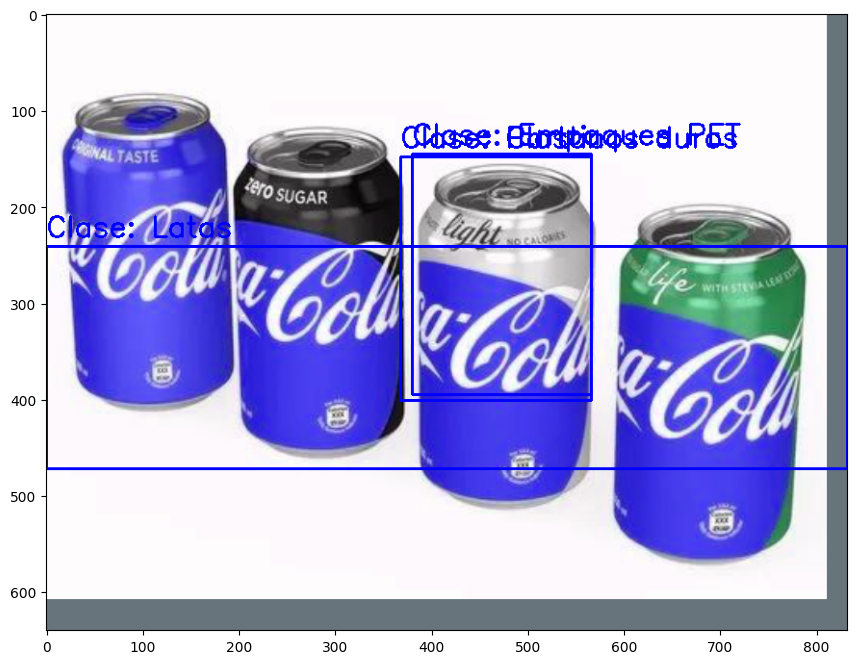

In [ ]:
# show_pred_on_image('./coke-can-500x500.jpg', retinanet, thres=0.2)
show_pred_on_image('coke-can-500x500.jpg', loaded_model, thres=0.2)

In [ ]:
!wget https://static3.bigstockphoto.com/7/3/2/large1500/237369025.jpg

--2023-06-19 07:13:25--  https://static3.bigstockphoto.com/7/3/2/large1500/237369025.jpg
Resolving static3.bigstockphoto.com (static3.bigstockphoto.com)... 13.33.33.118, 13.33.33.61, 13.33.33.67, ...
Connecting to static3.bigstockphoto.com (static3.bigstockphoto.com)|13.33.33.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143098 (140K) [image/jpeg]
Saving to: ‘237369025.jpg’

237369025.jpg       100%[===================>] 139.74K   222KB/s    in 0.6s    

2023-06-19 07:13:27 (222 KB/s) - ‘237369025.jpg’ saved [143098/143098]



torch.Size([1, 3, 640, 832])

 Total Time - 0.11418271064758301

Clasificacion


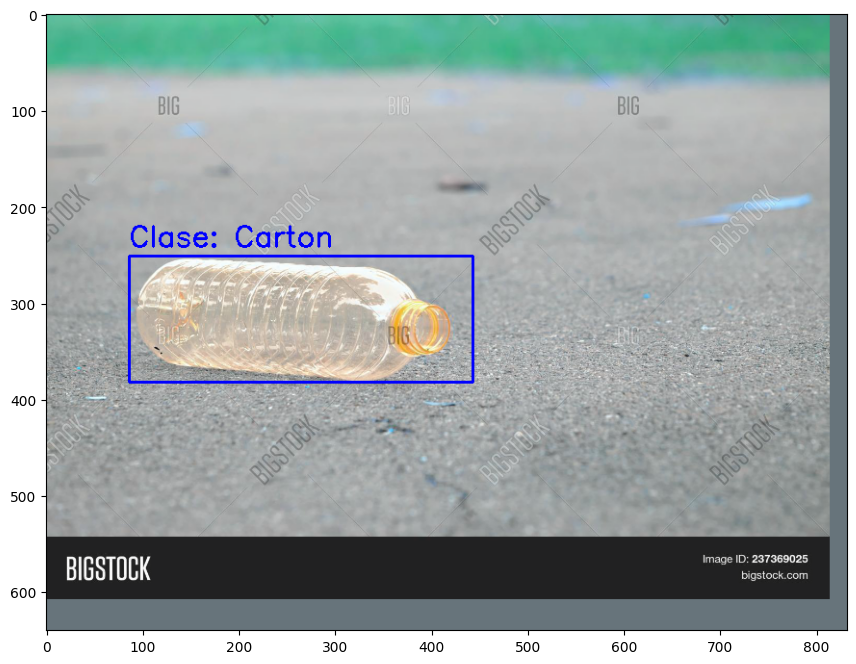

In [ ]:
show_pred_on_image('237369025.jpg', loaded_model, thres=0.2)

torch.Size([1, 3, 640, 832])

 Total Time - 0.11399602890014648

Clasificacion


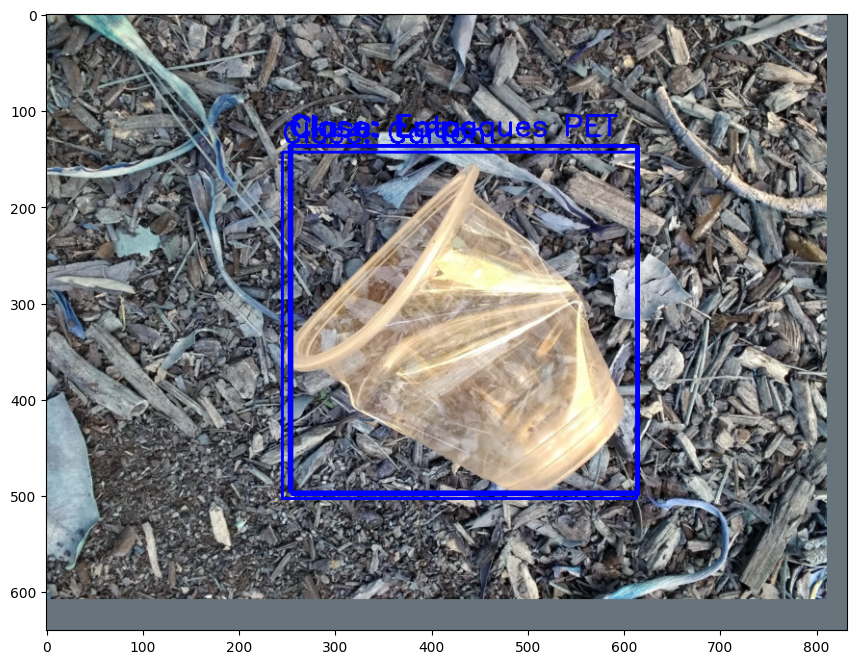

In [ ]:
show_pred_on_image('/content/drive/MyDrive/TT/TRASHDETECTION/data/batch_14/000001.jpg', loaded_model, thres=0.2)